

# Статистический анализ данных сервиса аренды самокатов GoFast


In [1]:
# импортируем необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np


#### Шаг 1. Загрузка данных

Считаем данные из csv-файлов: **'/datasets/users_go.csv' , '/datasets/rides_go.csv', '/datasets/subscriptions_go.csv'** и напечатем таблицы для ознокомления.


In [2]:
df_users = pd.read_csv('users_go.csv')

df_rides = pd.read_csv('rides_go.csv')

df_subscriptions = pd.read_csv('subscriptions_go.csv')



display(df_users.head(), df_rides.head(), df_subscriptions.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Изучим общую информацию о датафрейме  df.users:

In [3]:
display(df_users.sample(10))
df_users.info()

,user_id,name,age,city,subscription_type
1543,153,Герман,23,Москва,ultra
326,327,Наташа,24,Краснодар,ultra
1172,1173,Алина,19,Пятигорск,free
1287,1288,Матвей,33,Ростов-на-Дону,free
1334,1335,Юлиана,27,Ростов-на-Дону,free
1531,1532,Алексей,26,Тюмень,free
545,546,Милена,22,Ростов-на-Дону,ultra
1333,1334,Мария,16,Ростов-на-Дону,free
81,82,Максим,19,Ростов-на-Дону,ultra
126,127,Павел,25,Пятигорск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме содержится 1565 строк, пропущенных значений нет. Датафрейм необходимо проверить на наличие  явных и неявных дубликатов. Типы данных не требуют изменений.

Изучим общую информацию о датафрейме `df_rides`:

In [4]:
display(df_rides.sample(10))
df_rides.info()

,user_id,distance,duration,date
16031,1392,235.127167,5.282512,2021-03-07
15084,1322,5285.797316,33.821740,2021-03-23
7872,799,3274.136803,14.541226,2021-04-18
3555,382,3493.109112,21.122042,2021-06-23
13767,1229,1133.592229,7.429126,2021-01-15
8716,866,2172.744938,6.828322,2021-07-02
14845,1306,3619.320786,16.686370,2021-03-03
8226,828,4315.378815,17.928370,2021-07-31
13200,1190,2860.320847,17.720642,2021-09-14
13703,1224,5179.707927,25.281322,2021-10-05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Датафрейм содержит 18068 строк, что достаточно для проведения  анализа в рамках проекта. Пропущенных 
значений нет. Проверим датафрейм на наличие явных  и неявных дубликатов, также преобразуем 
 типы данных, придерживаясь следующих принципов:
1. Там где возможно и целесообразно приведем данны к целочисленному типу.
2. Данные с датами приведем к типу данных datetime.

Изучим общую информацию о датафрейме `df_subscriptions`:

In [5]:
display(df_subscriptions)
df_subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Датафрейм с метаданными, дополняйщий информацию в датафрейме `df_users`, предобрабтка не требуется.

#### Шаг 2. Предобработка данных

##### Предобработка данных в таблице `df_users`

Проверим наличие явных дубликатов в таблице и удалим найденные.


In [6]:
df_users.duplicated().sum()

31

In [7]:
df_users = df_users.drop_duplicates()
df_users.duplicated().sum()

0

Проверим столбцы `name`,`city`на наличие неявных дубликтов.

In [8]:
print(f'количество уникальных имен: {len(df_users["name"].unique())}')
sorted(df_users['name'].unique())

количество уникальных имен: 194


['Агата',
 'Аделина',
 'Адель',
 'Айдар',
 'Александр',
 'Александра',
 'Алексей',
 'Алина',
 'Алиса',
 'Алия',
 'Алла',
 'Альберт',
 'Альбина',
 'Алёна',
 'Амалия',
 'Амина',
 'Амир',
 'Анастасия',
 'Анатолий',
 'Ангелина',
 'Андрей',
 'Анжелика',
 'Анна',
 'Антон',
 'Антонина',
 'Ариана',
 'Арина',
 'Арсен',
 'Арсений',
 'Артемий',
 'Артур',
 'Артём',
 'Богдан',
 'Борис',
 'Вадим',
 'Валентина',
 'Валерий',
 'Валерия',
 'Варвара',
 'Василий',
 'Василина',
 'Василиса',
 'Вера',
 'Вероника',
 'Виктор',
 'Виктория',
 'Виолетта',
 'Виталий',
 'Виталина',
 'Влад',
 'Влада',
 'Владимир',
 'Владислав',
 'Владислава',
 'Всеволод',
 'Вячеслав',
 'Галина',
 'Георгий',
 'Герман',
 'Глеб',
 'Гордей',
 'Григорий',
 'Давид',
 'Дамир',
 'Даниил',
 'Данил',
 'Данила',
 'Даниэль',
 'Дарина',
 'Дарья',
 'Демид',
 'Денис',
 'Диана',
 'Дмитрий',
 'Ева',
 'Евгений',
 'Евгения',
 'Егор',
 'Екатерина',
 'Елена',
 'Елизавета',
 'Елисей',
 'Есения',
 'Жанна',
 'Зарина',
 'Захар',
 'Злата',
 'Иван',
 'Игнат',

 В столбце содержатся 194 уникальных  имени клиентов сервиса, и при визуальном осмотре  списка
    неявных дубликатов не обнаружено.
    
Проверим столбец `cyty` на неявные дубликаты.

In [9]:
print(f'количество уникальных имен: {len(df_users["city"].unique())}')
sorted(df_users['city'].unique())

количество уникальных имен: 8


['Екатеринбург',
 'Краснодар',
 'Москва',
 'Омск',
 'Пятигорск',
 'Ростов-на-Дону',
 'Сочи',
 'Тюмень']

В столбце содержится 8 уникальных имен, неявных дубликатов не обнаружено.

Убедимся в том, что столбец `subscription_type`содержит только два уникальных названия, которые
можно будет использовать в качестве маркеров категорий.

In [10]:
df_users[['subscription_type']].value_counts()

subscription_type
free                 835
ultra                699
dtype: int64

##### Предобработка данных в таблице `df_rides`

Проверим наличие явных дубликатов в таблице и удалим найденные.

In [11]:
df_rides.duplicated().sum()

0

In [12]:
df_rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Приведем  столбец `date` к типу данных **datetime**.

Данные в столбце `distance` округлим до целочисленного значения и приведем к **'int64'**.

Данные  о продолжительносьти поездки из столбца `duration`округлим до следующего цлого и преведем к **'int64'**. 

Проверим результат методом .info(), также выведем несколько строк таблицы

In [13]:
df_rides['date'] = pd.to_datetime( df_rides['date'], format = '%Y-%m-%d')
df_rides['distance'] = df_rides['distance'].round().astype('int')
df_rides['duration'] =np.ceil(df_rides['duration']).astype('int')
display(df_rides.info(),df_rides.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  int32         
 2   duration  18068 non-null  int32         
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 423.6 KB


None

,user_id,distance,duration,date
0,1,4410,26,2021-01-01
1,1,2618,16,2021-01-18
2,1,754,7,2021-04-20
3,1,2695,19,2021-08-11
4,1,4029,27,2021-08-28


Создадим столбец с номeром месяца `month_` на основе столбца `date`. Номер месяца возможно использовать для агрегации данных
помесячно, при условии, что интервал времени охватывает полный год. В случае отсутствия такого соответствия требуется разбивка данных по годам.

In [16]:
df_rides['date'].dt.year.value_counts()

2021    18068
Name: date, dtype: int64

Убедились, что данные охватывают период  в один год.

In [17]:
df_rides['month'] = df_rides['date'].dt.month

In [18]:
df_rides.head() 

,user_id,distance,duration,date,month
0,1,4410,26,2021-01-01,1
1,1,2618,16,2021-01-18,1
2,1,754,7,2021-04-20,4
3,1,2695,19,2021-08-11,8
4,1,4029,27,2021-08-28,8


Количество пользователей без подписки превышает общее число пользователей, за исключением Москвы и Омска, где оно одинаково.

##### Оценка возраста пользователей

In [19]:
df_users.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


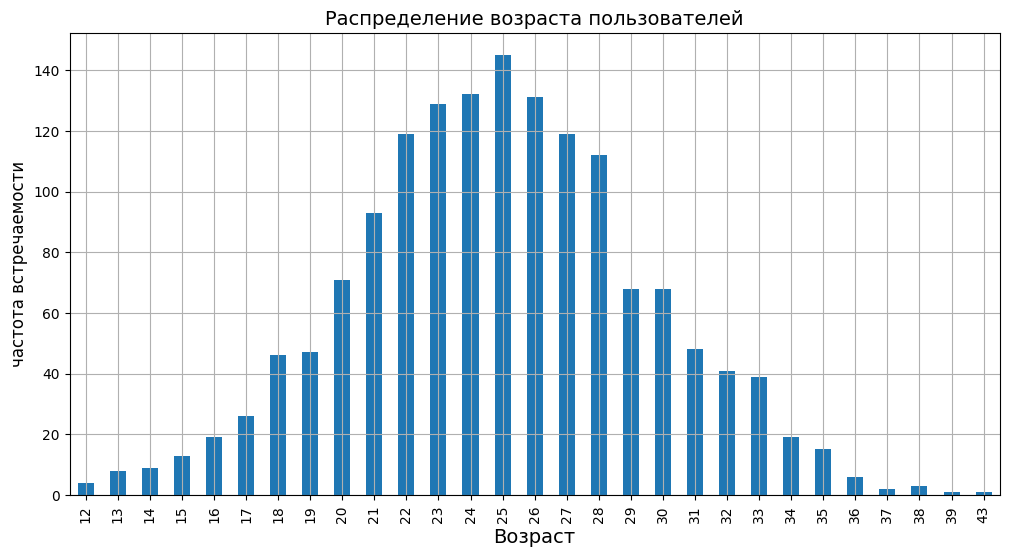

In [20]:
df_users.pivot_table(index = 'age',values = 'user_id', aggfunc ='count')\
                  .plot(kind = 'bar',figsize=(12,6),legend=False, grid=True)
plt.title('Распределение возраста пользователей',fontsize = 14)
plt.xlabel('Возраст',fontsize = 14)
plt.ylabel('частота встречаемости',fontsize=12)
plt.show()

Распределение возраста пользователей близко к нормальному. Медианное и среднее значения составляют около 25 лет, что указывает на симметричность распределения. Максимальный возраст клиентов составляет 43 года, в то время как минимальный возраст — 12 лет.

 Отметим, что в представленных данных отсутствуют аномальные значения.

##### расстояние для одной поездки


In [21]:
df_rides.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659010,18.303520,6.486772
std,434.734317,1116.832209,6.094928,3.437410
min,1.000000,1.000000,1.000000,1.000000
25%,487.000000,2543.000000,14.000000,4.000000
50%,889.000000,3134.000000,18.000000,6.000000
75%,1213.250000,3776.000000,22.000000,9.000000
max,1534.000000,7211.000000,41.000000,12.000000


Построим гистограммы с разным диапазоном значений и боксплот для оценки выбросов.

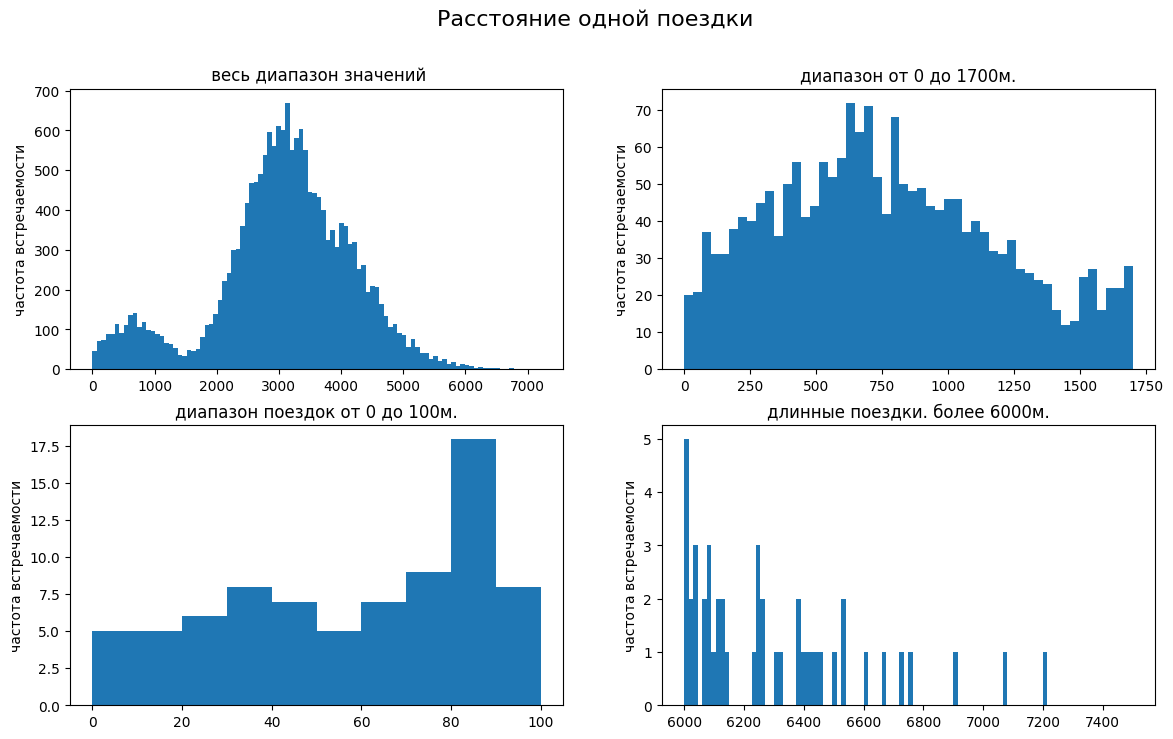

In [22]:
# создадим фигуру  с двумя строками  идвумя столбцами.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
fig.suptitle('Расстояние одной поездки', fontsize=16)

axes[0,0].hist(df_rides['distance'],bins=100,)
axes[0,0].set_title(' весь диапазон значений')
axes[0,0].set_ylabel('частота встречаемости',fontsize=10)

axes[0,1].hist(df_rides['distance'],bins=50,range = (0,1700))
axes[0,1].set_title('диапазон от 0 до 1700м.')
axes[0,1].set_ylabel('частота встречаемости',fontsize=10)

axes[1,0].hist(df_rides['distance'],bins=10,range = (0,100))
axes[1,0].set_title('диапазон поездок от 0 до 100м.')
axes[1,0].set_ylabel('частота встречаемости',fontsize=10)

axes[1,1].hist(df_rides['distance'],bins=100,range = (6000,7500))
axes[1,1].set_title('длинные поездки. более 6000м.')
axes[1,1].set_ylabel('частота встречаемости',fontsize=10)
plt.show()

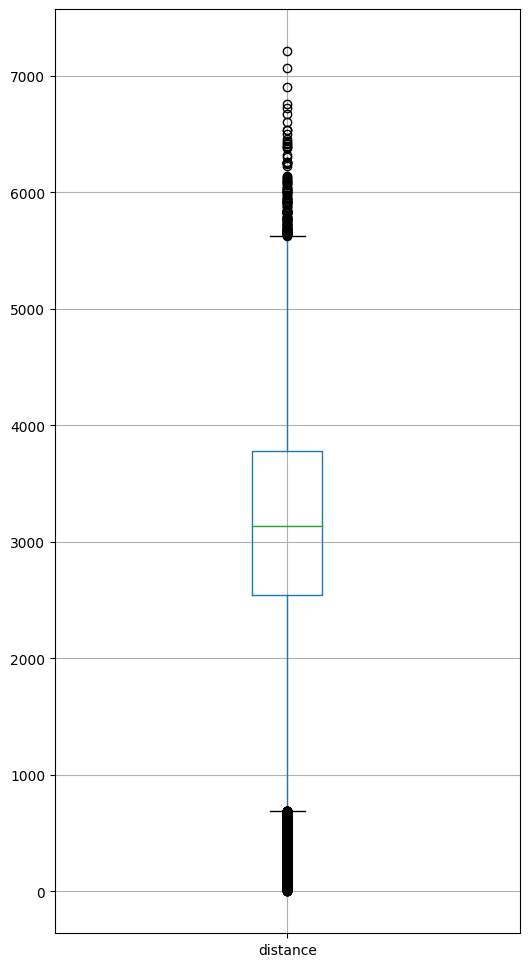

In [23]:
df_rides[['distance']].boxplot(figsize=(6,12))
plt.show()

На гистограмме, охватывающей весь диапазон выделяются две основные области распределения расстояний по поездкам:
1. Короткие поездки (0-1500 м): Наблюдается небольшая область коротких поездок с пиком, приходящимся  на 750 метров.
2. Долгие поездки (примерно 3300 м): Основная доля поездок сосредотачивается в области длинных расстояний, с пиком, приходящимся
    на 3300 метров.
    
Отделено стоит рассмотреть короткие поездки дальностью менее 100м. Решение об их удалении примем после исследования длительности поездок.

Поездки на расстояние более 5700 метров, хотя относятся к выбросам согласно диаграмме размаха, оставим в датафрейме, так как они вписываются в логику работы сервиса и не кажутся слишком завышенными.

Также оставим поездки с расстоянием менее 800 метров, несмотря на данные боксплота.

Рассмотрим срез датафрейма с дистанциями менее 100 и оценим его размер.







In [24]:
df_rides.query('distance<100')

,user_id,distance,duration,date,month
6611,707,29,15,2021-09-12,9
6691,712,24,3,2021-11-22,11
6816,721,63,8,2021-09-25,9
6850,724,30,4,2021-05-09,5
7367,760,55,9,2021-10-13,10
...,...,...,...,...,...
17414,1489,22,7,2021-10-06,10
17502,1495,79,10,2021-05-16,5
17646,1506,37,5,2021-06-27,6
17722,1511,87,4,2021-01-21,1


Количество таких поездок невилико и составляет менеее 0.5% от общего числа.

##### Исследование продолжительности поездки.

Построим гистограммы для всего диапазона и для диапазона  коротких поездок до 5 мин.

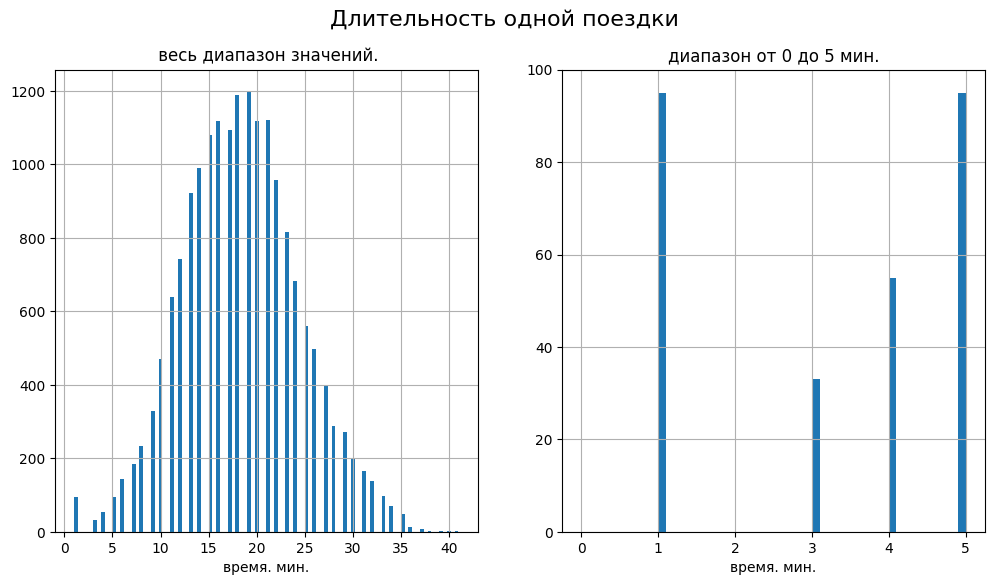

In [25]:
# создадим фигуру для двух графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Длительность одной поездки', fontsize=16)
# гистограмма для всего диапазона значений
axes[0].hist(df_rides['duration'],bins=100)
axes[0].set_title(' весь диапазон значений.')
axes[0].set_xlabel('время. мин.')
axes[0].grid(True)

# диаграмма для диапазона (0,5)
axes[1].hist(df_rides['duration'],bins=50,range = (0,5))
axes[1].set_title('диапазон от 0 до 5 мин.')
axes[1].set_xlabel('время. мин.')
axes[1].set_ylim(0,100)
axes[1].grid(True)
plt.show()

На гистограммах заметен выброс при значении 1 мин. Выручка сервиса зависит от времени ииспользования самоката. Исследуем поздки
длительностью в одну минуту, проанализируем расстояния таких поездок. 



In [26]:
df_rides.query('duration ==1 ')[['distance']].describe()


,distance
count,95.000000
mean,5113.168421
std,658.312505
min,4030.000000
25%,4611.500000
50%,5053.000000
75%,5488.500000
max,7211.000000


 Исследуемые  поездки находятся в диапазоне от 4030м до 7211м, что позволяет сделать вывод о недостоверности указанного времени в 1 минуту на преодоление таких расстояний. Доля таких поездок составляет около 1%
Классифицируем их как  аномалии и удалим такие записи.

Рекомендуем техническим службам более детально изучить и устранить прчины таких аномалий. Даже небольшая доля таких случаев снижает  выручку.

In [27]:
df_rides = df_rides.query('duration !=1')


Проверим  короткие поездки на предмет аномальных расстояний.

In [28]:
df_rides.query('duration<=5').pivot_table(index='duration',values='distance', aggfunc='max')

,distance
duration,
3,466
4,753
5,1310


В оставшихся коротких поездках аномалий невыявлено.

После произведенных измений выведем статистические данные, отражающие основные данные о поездках  и подведем итоги.

In [29]:
df_rides.describe()

,user_id,distance,duration,month
count,17973.000000,17973.000000,17973.000000,17973.000000
mean,841.551995,3059.862905,18.394981,6.486786
std,435.144929,1108.815513,5.979419,3.436024
min,1.000000,1.000000,3.000000,1.000000
25%,484.000000,2539.000000,14.000000,4.000000
50%,887.000000,3129.000000,18.000000,6.000000
75%,1213.000000,3763.000000,22.000000,9.000000
max,1534.000000,7066.000000,41.000000,12.000000


Общее количество пользователей сотавляет 1534 человека, из них 699 с подпиской 835 без.
Количество пользователей без подписки превышает общее число пользователей, за исключением Москвы и Омска, где оно одинаково.

Среднее значение возраста составляют около 25 лет. Максимальный возраст клиентов составляет 43 года, в то время как минимальный возраст — 12 лет.

Среднее расстояние поездки составляет 3059м, при этом максимальное расстояние достигает 7066м., а минимальное 1м.

Среднее время, затраченное на одну поездку составляет около 18мин.м,при этом максимальное время составляет 41мин., а минимальное 3 мин.

В данных были аномальные значения поездок длительность 1 мин на расстояние в диапазоне от 4030м до 7211м.
Рекомендуем техническим службам более детально изучить устранить причины появления таких аномалий.

#### Шаг 4. Объединение данных

Объединим  датафремы `df_rides`,`df_users`,`df_subscriptions` и запишем в новую таблицу:  
**`data_total `**


In [30]:
# присоединеним df_users к df_rides по общему столбцу user_id и запишем в data_total.
data_total = df_rides.merge(right=df_users, how='left', on='user_id')

# к data_total присоединим df_subscriptions по общему столбцу subscription_type.
data_total = data_total.merge(right=df_subscriptions, on='subscription_type',how='left' )


Оценим корректность объединения таблиц.

In [31]:
print(f'Размер df_rides:{df_rides.shape}, размер df_users:{df_users.shape}, размер df_subscriptions:{df_subscriptions.shape}')
print(f'размер итогового датафрема data_total:{data_total.shape}')

Размер df_rides:(17973, 5), размер df_users:(1534, 5), размер df_subscriptions:(2, 4)
размер итогового датафрема data_total:(17973, 12)


Данные присоединяли к `data_rides`.
Kоличество строк в `data_total` и в `data_rides` равное.
Количество столбцов `data_total` равно 12, что соответствует количеству  столбцов в объединяемых датафреймах за минусом двух
общих.

Проверим пропуски и тип данных в `data_total` и выведем несколько строк итоговой таблицы.


In [32]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  int32         
 2   duration           17973 non-null  int32         
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(6), object(3)
memory usage: 1.6+ MB


In [33]:
data_total.head()


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4410,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2618,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2695,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4029,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [34]:
data_total_ultra = data_total.query('subscription_type == "ultra"')
data_total_free = data_total.query('subscription_type == "free"')

In [35]:
data_total_ultra.sample(5) 

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
4086,440,2760,18,2021-05-14,5,Амалия,20,Тюмень,ultra,6,0,199
256,27,3087,16,2021-07-12,7,Эдуард,20,Краснодар,ultra,6,0,199
2967,319,2760,13,2021-02-17,2,Юрий,26,Омск,ultra,6,0,199
4532,488,2966,18,2021-11-24,11,Владимир,31,Пятигорск,ultra,6,0,199
4971,535,3482,16,2021-07-10,7,Юрий,25,Ростов-на-Дону,ultra,6,0,199


In [36]:
data_total_free.sample(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
11360,1058,191,5,2021-09-27,9,Артемий,25,Омск,free,8,50,0
7021,736,2951,15,2021-05-21,5,Ильдар,26,Пятигорск,free,8,50,0
8320,836,4170,22,2021-07-23,7,Всеволод,21,Тюмень,free,8,50,0
9792,946,4057,15,2021-07-29,7,Олег,29,Екатеринбург,free,8,50,0
16208,1409,2128,11,2021-12-16,12,Юрий,29,Екатеринбург,free,8,50,0


Проверим размерности полученных датофреймов  с исходным

In [37]:
# размеры определим методом shape[0], выведем сумму полученных датафреймов и размер исходного.
print(f'Совокупный размер созданных датафремов:{data_total_free.shape[0]+data_total_ultra.shape[0]} \n\
Размер исходного датафрейма:{data_total.shape[0]}')


Совокупный размер созданных датафремов:17973 
Размер исходного датафрейма:17973


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

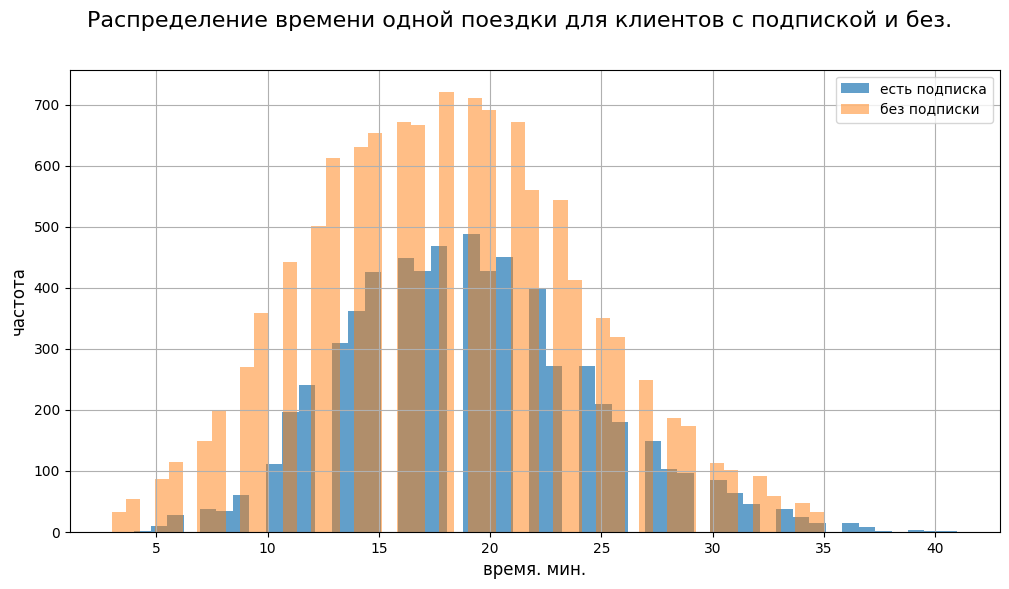

In [38]:
# создадим фигуру для двух графиков
fig, axes = plt.subplots(figsize=(12, 6))
fig.suptitle('Распределение времени одной поездки для клиентов с подпиской и без.'
             , fontsize=16)
# гистограмма для всего диапазона значений
axes.hist(data_total_ultra['duration'],bins=50,label='есть подписка', alpha=0.7)
axes.set_xlabel('время. мин.',fontsize=12)
axes.grid(True)
axes.set_ylabel('частота',fontsize=12)

# диаграмма для диапазона (0,5)
axes.hist(data_total_free['duration'],bins=50, label='без подписки',alpha=0.5)
axes.legend()
plt.show()

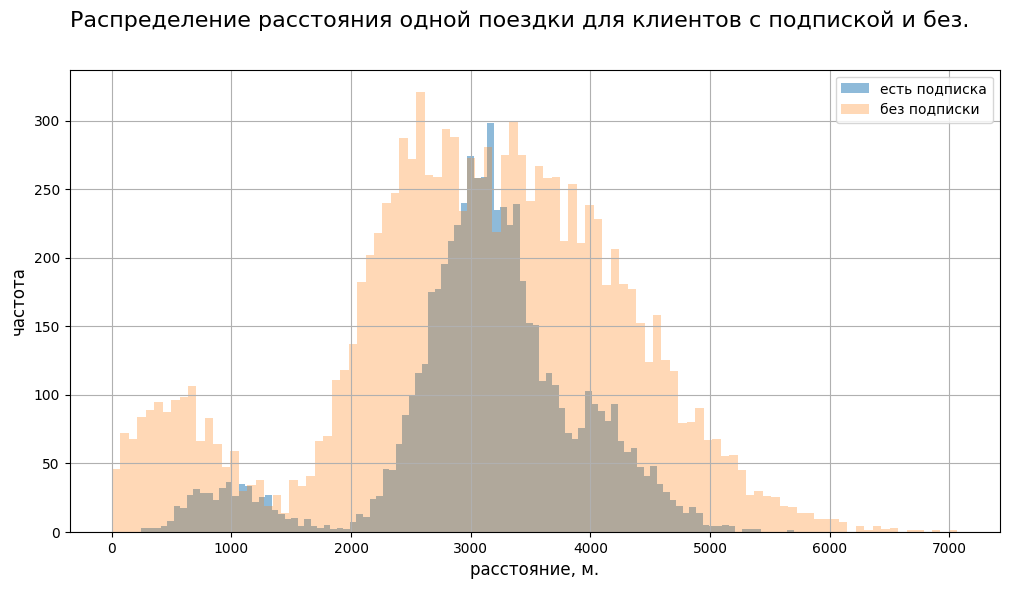

In [39]:
# создадим фигуру для двух графиков
fig, axes = plt.subplots(figsize=(12, 6))
fig.suptitle('Распределение расстояния одной поездки для клиентов с подпиской и без.'
             , fontsize=16)
# гистограмма для всего диапазона значений
axes.hist(data_total_ultra['distance'],bins=100,alpha=0.5,label='есть подписка')
axes.set_xlabel('расстояние, м.',fontsize=12)
axes.grid(True)
axes.set_ylabel('частота',fontsize=12)
# диаграмма для диапазона (0,5)

axes.hist(data_total_free['distance'],bins=100,alpha=0.3,label='без подписки')
axes.legend()
plt.show()

Составим таблицу с основными статтистическим  характеристиками:
1. Клиенты с подпиской - столбцы `distance_ultra`,`duration-ultra`, соответственно расстояние  и время.
2. Клиенты без подписки - столбцы `distance_ultra`,`duration-ultra`, соответственно расстояние  и время.

In [40]:
# создадим датафрейм data_stat, объединив  в него таблицы  со стат. данными, полученными
# методом .describe().
data_stat = pd.concat(
      [data_total_ultra[['distance','duration']].describe(),
      data_total_free[['distance','duration']].describe()],
      axis=1 )
# переименуем столбцы.
data_stat.columns =['distance_ultra','duration_ultra','distance_free','duration_free']  
data_stat

,distance_ultra,duration_ultra,distance_free,duration_free
count,6500.000000,6500.000000,11473.000000,11473.000000
mean,3115.443385,19.037692,3028.373921,18.030855
std,836.898137,5.577439,1235.541284,6.166175
min,244.000000,4.000000,1.000000,3.000000
25%,2785.000000,15.000000,2361.000000,14.000000
50%,3149.000000,19.000000,3102.000000,18.000000
75%,3561.000000,22.000000,3884.000000,22.000000
max,5700.000000,41.000000,7066.000000,35.000000


Сравнительный анализ между клиентами с подпиской и без показывает, что средние и медианные значения для расстояния и времени поездки в обеих категориях не имеют значительных различий..К тому же среднее значение близкое к медианному,
 указывает на отсутствие существенных выбросов и нормальное распределение данных.
 
Ллиенты без подписки имеют более высокие максимальные показатели дистанции по сравнению с теми, у кого есть подписка, при этом
время одной поездки остается примерно одинаковым для обеих категорий.




#### Шаг 5. Подсчёт выручки

In [41]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  int32         
 2   duration           17973 non-null  int32         
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(6), object(3)
memory usage: 1.6+ MB


Создадим датафрем `data_total_agg`с агрегированными c данными по каждому клиенту помесячно:
1. Суммарное расстояние.
2. Количество поездок
3. Суммарное время.

Также добавим в таблицу `data_total_agg` столбец  с помесячной выручкой от каждого пользователя.

За основу возьмем данные датафрема `data_total`.

Создадим data_total_agg, объект типа DataFrameGroupBy, сгруппированный по столбцам `user_id`, `month`датафрема `data_total`.
Сформируем агрегированный датофрейм `data_total_agg`со столбцами:
1. `distance` - суммарное расстояние.(метод .sum )
2. `name`- количество поездок. (метод .count)
3.  `duration`-cуммарное время поездок (метод .sum)
4. `start_ride_price`- стоимость поездки без подписки (метод .max)
5. `subscription_fee`- стоимость подписки на месяц (метод.max)
6.  `minute_price ` - стоимость минуты(метод .max)

Добавим столбец `revenue`, для этого перемножим значения соответствующих ячеек в столбцах `minute_price` и `duration`, затем прибавим значения соответствующих ячеек столбцов `start_ride_price` и `subscription_fee`.
Результатом будет помесячная выручка от каждого клиента.

Переименуем столбец `name` в `trips`.

                                                                                               

In [42]:
# cгруппируем датафрейм 'data-total' по столбцам `user_id`, `month`.
data_total_agg = data_total.groupby(by=['user_id','month'])
# сформируем датафрейм 'data_total_agg'
data_total_agg= data_total_agg.agg({'distance':'sum','name':'count','duration':'sum','minute_price':'max',
                                      'start_ride_price':'max','subscription_fee':'max'}).reset_index()
# добавим столбец 'revenue'
data_total_agg['revenue'] =data_total_agg\
.apply(lambda x: x['minute_price']*x['duration']+x['start_ride_price']*x['name']+x['subscription_fee'],axis=1)

# переименуем столбец 'name' в 'trips' 
data_total_agg.rename(columns={'name':'trips'}, inplace=True)

data_total_agg 

,user_id,month,distance,trips,duration,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7028,2,42,6,0,199,451
1,1,4,754,1,7,6,0,199,241
2,1,8,6724,2,46,6,0,199,475
3,1,10,5810,2,32,6,0,199,391
4,1,11,7004,3,56,6,0,199,535
...,...,...,...,...,...,...,...,...,...
11295,1534,6,3409,2,26,8,50,0,308
11296,1534,8,7623,2,48,8,50,0,484
11297,1534,9,4928,1,23,8,50,0,234
11298,1534,11,13349,4,78,8,50,0,824


#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки.

Сформулируем нулевую гипотезу **HO: время, затраченное на поездки пользователями с подпиской и без одинковое**.
Альтернативная гипотеза **Н1 время, затраченное на поездки  пользователей с подпиской в целом больше времени затраченного на поездки пользователей без подписки**.

Проверим Н0 на уровне статитстической значимости 5%.  

In [43]:
display(data_total_ultra[['duration']].describe(),data_total_free[['duration']].describe())

,duration
count,6500.000000
mean,19.037692
std,5.577439
min,4.000000
25%,15.000000
50%,19.000000
75%,22.000000
max,41.000000


,duration
count,11473.000000
mean,18.030855
std,6.166175
min,3.000000
25%,14.000000
50%,18.000000
75%,22.000000
max,35.000000


In [44]:
alpha= 0.05
results = st.ttest_ind(data_total_ultra['duration'],data_total_free['duration']
                       ,alternative='greater')
print(f'значение p-value : {results.pvalue}')
if results.pvalue < alpha:
    print(f'На уровне значимости {alpha}, отвергается нулевая гипотеза H0')
else:
    print(f'Нулевая гипотеза H0:не отвергается на уровне значимости {alpha}') 
    
   

значение p-value : 8.577910347796266e-28
На уровне значимости 0.05, отвергается нулевая гипотеза H0


Нулевая гипотеза Н0:время, затраченное на поездки пользователями с подпиской и без одинаковое, отвергнута,
есть основания утверждать, что **время, затраченное на поездки  пользователей с подпиской в целом больше времени затраченного на поездки пользователей без подписки**.

##### Соответствие расстояния одной поездки пользователей с подпиской максимальному.

С точки зрения износа самоката оптимальное расстояние поездки 3130 м.
Сформулируем нулевую гипотезу **Н0:среднее расстояние одной поездки для пользователей с подпиской
 равно 3130м или меньше**.

Альтернативная гипотеза **Н1: среднее расстояние одной поездки для пользователей с подпиской больше 3130м.**.

Проверим Н0 на уровне статитстической значимости 5%.

In [45]:
#
distance = 3130
# уровень статистической значимости
alpha=0.05
# датафрем data_total_ultra- данны  о пользователях с подпиской
results =  st.ttest_1samp(data_total_ultra['distance'], distance, alternative='greater')
print(f'значение p-value : {results.pvalue}')

if results.pvalue < alpha:
    print(f'На уровне значимости {alpha}, отвергается нулевая гипотеза H0')
else:
    print(f'Нулевая гипотеза H0:не отвергается на уровне значимости {alpha}') 
   

значение p-value : 0.9195649894697724
Нулевая гипотеза H0:не отвергается на уровне значимости 0.05


Результаты статистического теста говорят о том, что среднее расстояние поездки для пользователей с подпиской, вероятно, меньше или равно 3130 м., **это может считаться оптимальным расстоянием с точки зрения износа самоката, поскольку данное значение находится в пределах установленной нормы**

#####  Сравнение помесячной выручки пользователей с подпиской и без.

Сформулируем нулевую гипотезу: **H0: помесячная выручка у клиентов с подпиской и без не отличается**.

Альтернативнач гипотеза: **Н1: помесячная выручка клиентов с подпиской выше чем у клиентов без подписки**.

Проверим Н0 на уровне статитстической значимости 5%.

Для проверки воспользуемся данными  таблицы `data_total_agg`, маркером пользователей без подписки
является значение '0' в столбце `subscription_fee`.

In [46]:
# уровень статистической значимости
alpha= 0.05
# сформируем выборки клиентов с подпиской  и без.
data_total_agg_ultra=data_total_agg.query('subscription_fee != 0')
data_total_agg_free=data_total_agg.query('subscription_fee == 0')
# проверка гипотезы на равенство среднего (правостороння H1)
results = st.ttest_ind(data_total_agg_ultra['revenue'],data_total_agg_free['revenue'],
                      alternative='greater' )
print(f'значение p-value : {results.pvalue}')
if results.pvalue < alpha:
    print(f'На уровне значимости {alpha}, отвергается нулевая гипотеза H0')
else:
    print(f'Нулевая гипотеза H0:не отвергается на уровне значимости {alpha}') 
   

значение p-value : 2.0314113674863288e-30
На уровне значимости 0.05, отвергается нулевая гипотеза H0


Результаты статистического теста говорят о том, что **помесячная выручка клиентов с подпиской статистически значимо превышает выручку, клиентов без подписки**.


##### Оценка и выбор метода проверки гипотезы.

В данном задании предлагается сравнить две зависимые выборки. Выборки
в задании будут парные, для одних и тех же пользователей изменятся количество обращений до и после
изменений. Для проверки гипотезы следует использовать метод **scipy.stats.ttest_rel()**, в качестве
аргументов передать две парные выборки до изменения и после. Проверять будем в сторону уменьшения т.к. логика работы сервисной
команды направлена на уменьшение количества обращений. При вызове этого метода параметру 'alternative'присвоим значение 'less', что позволяет проверить гипотезу о том, что среднее количество обращений во второй выборке меньше, чем в первой.

В результате проверки гипотез пришли кследующим выводам:
1. Время, затраченное на поездки пользователей с подпиской в целом больше времени затраченного на поездки пользователей без подписки.
2. Среднее расстояние поездки для пользователей с подпиской, вероятно, меньше или равно 3130 м., это может считаться оптимальным расстоянием с точки зрения износа самоката, поскольку данное значение находится в пределах установленной нормы.
3. Результаты статистического теста говорят о том, что помесячная выручка клиентов с подпиской статистически значимо превышает выручку, клиентов без подписки.


#### Шаг 7. Распределения

#####  Расчет минимального количества промокодов для достижения целевого покрытия аудитории.

Акция c раздачей промокодов на подписку моделируется биноминальным распределением c вероятностью упеха p=0.1. Число испытаний  n подберем таким, чтобы P(X>=100)>=95% ( вероятность продления 100 
подписок 95%).Найдем такое значение n при котором выполняется условие:
{F(99,n)<0.05,F(99,n-1)>=0.05)}. 


количество промокодов 1161, P(X1=100)=95.02%


C:\Users\dmitr\anaconda3\envs\final_practicum\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


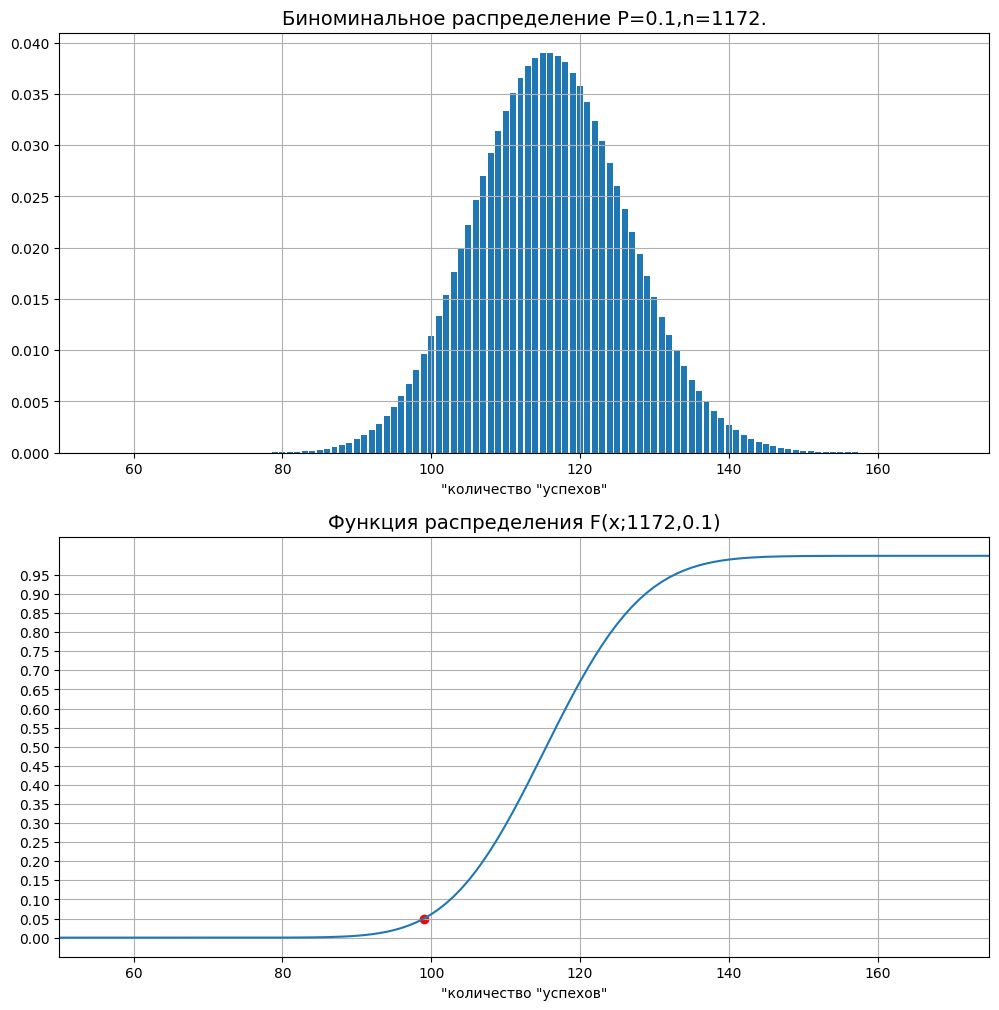

In [47]:
from scipy.stats import binom
# количество попыток.
n=100
# вероятность успеха
p=0.1
# количество успехов
k=99 
# цикл будет выполнятся до выполнения условия F(100)<5%
while binom.cdf(k,n,p)>=0.05:
    #print(binom.cdf(k,n,p),n)
    n=n+1
print(f'количество промокодов {n}, P(X1=100)={(1-binom.cdf(k,n,p)):.2%}')

# distr_pmf, distr_cdf соответственно массивы для B(1172,0.1)  pmf и cdf соответственно
distr_pmf = []
distr_cdf = []
for t in range(0,n+1):
    distr_pmf.append (binom.pmf(t,n,p))
    distr_cdf.append (binom.cdf(t,n,p))
# создадим фигуру из двух строк для графиков pmf , cdf    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
# график pmf 
axes[0].bar(range(0,n+1),distr_pmf)
axes[0].set_title('Биноминальное распределение P=0.1,n=1172.',fontsize = 14)
axes[0].set_xlabel('"количество "успехов"')
axes[0].grid(True)
axes[0].set_xlim(50, 175)

# график сdf
axes[1].plot(range(0,n+1),distr_cdf)
axes[1].set_title('Функция распределения F(x;1172,0.1)',fontsize = 14)
axes[1].set_xlabel('"количество "успехов"')
axes[1].grid(True)
axes[1].set_xlim(50, 175)
new_y_ticks = np.arange(0, 1, 0.05)  # Пример: от 0 до 1 с шагом 0.1
axes[1].set_yticks(new_y_ticks)
axes[1].scatter([99], [ 0.04954795210203071], color='red')
plt.show()


Биноминальное распределене Х ~(1161,0.1) соответствует условию поставленной задачи. Для успешной реализации акции, в которой планируется привлечение сто новых подписчиков с вероятностью не выполнения плана менее 5%, необходимо раздать как минимум 1161 промокода.

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера v_1: <a class="tocSkip"> </h2>
    
⚠️ Только здесь k не 100, а 99 будет. Т.к. в задании указано, что как минимум 100 клиентов должны продлить подписку, а не "более 100 клиентов". Нужно найти такое минимальное значение, чтобы вероятность не выполнить план (меньше 100) была равна 0.05. 


<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2>Комментарий студента v_1: <a class="tocSkip"> </h2>

Исправил.

При выполнении задания я долго колебался и выбрал неправильный вариант.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера v_2: <a class="tocSkip"> </h2>
    
✅ 1161 - правильный результат

##### Оценка вероятности просмотра пользователями уведомления.

Вероятность просмотра пользователем уведомленя составляет 40%, p=0.4.
Количество уведомлений 1.000.000 шт., n=1e+6.
Найдем вероятность того, что уведомление откроют не болеее 399.500 человек.

Данная задача моделируется биноминальным распределением, но исходя из характера вопроса, учитывая что вероятность 'успеха'приближается к 0.5 и количество опытов достаточно велико можно использовать апроксимацию биноминального распределения нормальным спарметрами:
1. Метиматическое ожидание Е=n*p
2. Диспрсия  SD^2=n*p(1-p)

Значеник CDF(a) , a=399500 будет вероятностью того что уведомление прочитают не более 399500 человек.

Также проверим условия апроксимации:интервал [E-3*SD,E+3*SD] лежит в диапазоне [0,n]
( в коде применим более жесткое условие[E-4*SD,E+4*SD] )

искомая вероятность 0.15
математическое ожидание400000, стандартное отклонение489.90,интервал [ 398040 ,401959 ]


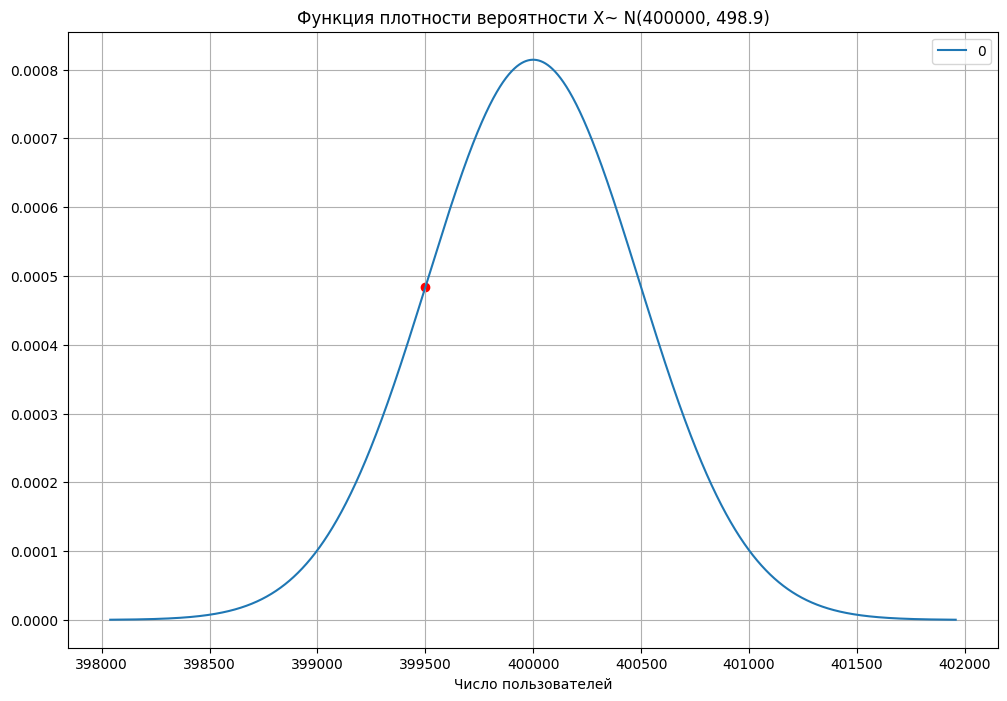

In [48]:
from scipy.stats import norm
from math import sqrt
p = 0.4
n=1e+6
value =399500
# расчитаем параметры для нормального распределения
mu =int(n*p)
sigma=sqrt(n*p*(1-p))
# вычислим cdf в целевой точке.
results = norm.cdf(value,mu,sigma)
print(f'искомая вероятность {results:.2f}')

# вычислим интервал распределения
left = int(n * p - 4 * sigma)
right = int(n * p + 4 * sigma)
print(f'математическое ожидание{mu}, стандартное отклонение{sigma:.2f},интервал [ {left} ,{right} ]')

# создадим массив значений в границах интервала [left, right] 
x = np.arange(left,right )
# создадим дата фрейм  с массивом pdf значений и индексами соответствующим массиву x
df_distr=pd.DataFrame(norm.pdf(x,mu,sigma))
df_distr['tick']=x
df_distr.set_index('tick', inplace=True)

#построим график плотности вероятности 
ax=df_distr.plot(figsize=(12,8),grid=True)
ax.scatter([399500], [ 0.000484], color='red')
ax.set_title('Функция плотности вероятности X~ N(400000, 498.9)')
ax.set_xlabel('Число пользователей')
plt.show()


Данная задача моделируется  нормальным распределением с математическое ожиданием 400000, стандартным отклонением 489.90.
Вероятность того, что уведомления откроют не более 399500 пользователей составляет 15%.


#### Общий вывод



В проекте исследованны данные сервиса аренды самокатов GoFast, проверены гипотезы, а также решены задачи с помощью
распределений вероятности. На этапе предобработки  проверили данные на наличие дубликатов и пропусков.
Обнаруженные дубликаты удалили, пропущенных значений не было. Данные в датафреймах привели к нужным форматам. 
В ходе исследования выяснили ,что для части  длительных поездок  в диапазоне от 4030м до 7211м. затрачивается
аномально малое время- минута. Рекомендуем техническим службам более детально изучить и устранить причины аномалии.


Объединили данные в один датафрейм, убедились в отсутсвии ошибок.

Основные выводы на этапе исследования данных:
1. GoFast имеет 1534 пользователя. Из них 699 с подпиской и 835 без. Количество пользователей без подписки превышает общее число пользователей, за исключением Москвы и Омска, где оно одинаково.
2. Средний возраст клиентов — 25 лет. Максимальный — 43 года, минимальный — 12 лет.
3. Среднее расстояние поездки — 3059 м, диапазон: 1м. - 7066 м.
4. Среднее время поездки — 18 мин, диапазон: 3 мин - 41 мин.

На этапе прверки гипотез пришли к следующим выводам:
1. Время, затраченное на поездки пользователей превышает время затраченное на поездки пользователей без подписки.
2. Среднее расстояние поездки для пользователей с подпиской, меньше или равно 3130 м., что является оптимальным с точки зрения
    износа самоката.
3. Помесячная выручка клиентов превышает выручку, клиентов без подписки.  

Определили, что для успешной маркетинговой акции необходимо распределить не менее 1161 промокодов.  
Рассчитали вероятность того, что заданное количество пользователей откроют уведомление - 15%.



